In [1]:
import numpy as np
from time import time
from PIL import Image
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F

In [2]:
DEVICE = torch.device("cuda")

# 获取 & 载入模型
net = get_model('r100',fp16=False).eval().to(DEVICE)
net.load_state_dict(torch.load('/private/data/backbone.pth'))

#这里的batch_size是干啥的?
batch_size = 80
image_dim = 112

def tensorToImage(im):return (im+1)/2

from dataset import MXFaceDataset,DataLoaderX
# 载入数据集
train_set = MXFaceDataset('/private/data/ms1m-retinaface-t1',local_rank=0)
a = DataLoaderX(local_rank=0,dataset=train_set,batch_size=1)

In [3]:
with torch.no_grad():
    for i in a:
        l = i[0]
        break
    emb_target = net(l)
    # print(emb_target)

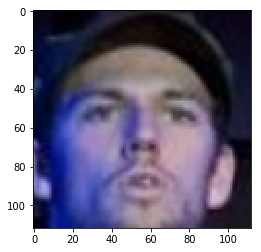

In [5]:

plt.imshow(tensorToImage(l[0]).permute(1, 2, 0).cpu().detach().numpy())

In [7]:
pipeline = Pipeline(emb_target,
                    net,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    sym_part=1,
                    multistart=True,
                    gauss_amplitude=0.02
                    )

In [8]:
(emb_target**2).sum()

tensor(621.8265, device='cuda:0')

In [9]:
cosines_target = []
facenet_sims = []

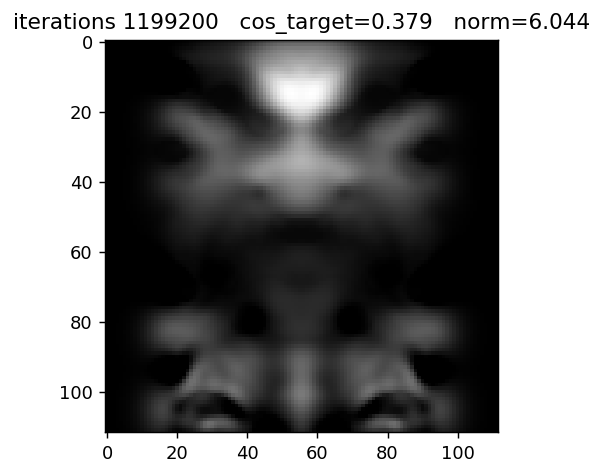

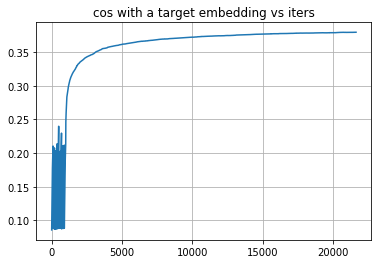

In [12]:
with torch.no_grad():
    for i in range(15000):
        start = time()
        
        recovered_face, cos_target = pipeline()
        
        cosines_target.append(cos_target)
        
        
        if i % 10 == 0:
            clear_output(wait=True)
            recovered_face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            recovered_face = recovered_face - np.min(recovered_face)
            recovered_face = recovered_face / np.max(recovered_face)
            
            plt.figure(dpi=130)
            plt.imshow(recovered_face)
            plt.title(f"iterations {i*pipeline.batch_size}   cos_target={round(cos_target,3)}   norm={round(pipeline.norm,3)}")
            plt.show()
            
            plt.plot(cosines_target)
            plt.grid()
            plt.title("cos with a target embedding vs iters")
            plt.show()